#  Использование предобученных моделей для классификации изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://pytorch.org/vision/stable/models.html
* https://albumentations.ai/docs/getting_started/image_augmentation/
* https://www.neurotec.uni-bremen.de/drupal/node/30

## Задачи для совместного разбора

1\. Загрузите предобученную модель из `torchvision`. Познакомьтесь с ее архитектурой. Заморозьте веса нескольких слоев.

Загрузка предобученных моделей из `torchvision` — это удобный способ использовать уже обученные архитектуры для вашей задачи. 

Что нужно знать:

- torchvision предоставляет множество предобученных моделей для различных задач: классификация, обнаружение объектов, сегментация.
- при загрузке модели вы можете указать, какие именно веса использовать; для некоторых моделей есть варианты
- предобученные модели могут служить отличной отправной точкой для решения вашей задачи
- предобученную модель нужно выбирать, исходя 
    - вашей задачи
    - того, на чем она училась и
    - ваших ресурсов (мощность машины)

In [3]:
import torchvision.models as models
import torch as th

model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.DEFAULT )

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to C:\Users\Rog G16/.cache\torch\hub\checkpoints\efficientnet_b1-c27df63c.pth


100%|██████████| 30.1M/30.1M [00:35<00:00, 879kB/s] 


Вы можете дообучить предобученную модель на своем наборе данных, что часто приводит к лучшим результатам, чем обучение с нуля. Это особенно полезно, если ваш набор данных мал или схож с тем, на котором модель была обучена.

Часто необходимо заменить последний полносвязный слой модели, чтобы он соответствовал числу классов в вашей задаче. Это легко сделать, просто нужно понять, как к нему обратиться.

In [4]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Нас интересует последний блок `classifier`

In [5]:
import torch.nn as nn
num_classes = 10
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

Теперь модель будет выдавать 10 чисел вместо 1000. Но новый вариант `nn.Linear` пока инициализирован случайным образом. Чтобы прогнозы были адекватные, модель надо дообучить. Варианты:

1. Просто берем эту модель и используем в стандартном цикле обучения. Обучаться будет последний слой, но вместе с ним и все предыдущие.
2. "Заморозить" все слои, кроме последнего (нового). Тогда обучаться будет последний слой, а остальные - не будут меняться
3. Промежуточный вариант: заморозить часть верхних слоев.

Что выбрать? Обычно:
-  более глубокие слои (ближе к выходу) отвечают за более специфические признаки, связанные с конкретной задачей (например, распознавание объектов) - эти слои часто требуют дообучения.
- первые слои обычно захватывают более общие признаки (например, края и текстуры), которые могут быть полезны для множества задач - их часто замораживают, чтобы сохранить эти общие представления.

Базовые интуиции:
- чем больше данных, тем больше можно оставить размороженным;
- в зависимости от того, насколько ваша задача близка к тому, на чем училась модель изначально, вы можете заморозить больше или меньше слоев

В итоге все сводится к тому, что вы должны экспериментировать и измерять качество.


Как замораживать: нужно соответствующему весу указать `requires_grad = False`. Обычно удобно сделать условие по названию. Названия параметров вместе с самими тензорами можно получить при помощи `named_parameters`.

Рекомендую использовать именно метод `requires_grad_` (пример ниже), так как при простом присваивании может закрасться ошибка (если нет средств анализа кода)

In [6]:
list(n for n, _ in model.named_parameters())

['features.0.0.weight',
 'features.0.1.weight',
 'features.0.1.bias',
 'features.1.0.block.0.0.weight',
 'features.1.0.block.0.1.weight',
 'features.1.0.block.0.1.bias',
 'features.1.0.block.1.fc1.weight',
 'features.1.0.block.1.fc1.bias',
 'features.1.0.block.1.fc2.weight',
 'features.1.0.block.1.fc2.bias',
 'features.1.0.block.2.0.weight',
 'features.1.0.block.2.1.weight',
 'features.1.0.block.2.1.bias',
 'features.1.1.block.0.0.weight',
 'features.1.1.block.0.1.weight',
 'features.1.1.block.0.1.bias',
 'features.1.1.block.1.fc1.weight',
 'features.1.1.block.1.fc1.bias',
 'features.1.1.block.1.fc2.weight',
 'features.1.1.block.1.fc2.bias',
 'features.1.1.block.2.0.weight',
 'features.1.1.block.2.1.weight',
 'features.1.1.block.2.1.bias',
 'features.2.0.block.0.0.weight',
 'features.2.0.block.0.1.weight',
 'features.2.0.block.0.1.bias',
 'features.2.0.block.1.0.weight',
 'features.2.0.block.1.1.weight',
 'features.2.0.block.1.1.bias',
 'features.2.0.block.2.fc1.weight',
 'features.2.0

In [7]:
model.features[0][0].weight.requires_grad

True

In [8]:
# пример
for n, w in model.named_parameters():
    if not n.startswith("classifier"):
        w.requires_grad_(False)

In [9]:
model.features[0][0].weight.requires_grad

False

In [10]:
# пример с ошибкой (рекомендую не присваивать напрямую)
for n, w in model.named_parameters():
    if not n.startswith("classifier"):
        w.required_grad = True

In [11]:
model.features[0][0].weight.requires_grad

False

При использовании предобученных моделей важно применять те же преобразования, которые были использованы при их обучении. Обычно это изменение размера (224x224 для многих моделей) и нормализация, но может быть что-то более сложное. Рекомендую отталкиваться от реализации той модели, которую вы загрузили. В `torchvision` можно достать объект для преобразования, а если берете откуда-то из другого места, то нужно читать документацию или (что бывает чаще) читать код.


In [12]:
t = models.EfficientNet_B1_Weights.IMAGENET1K_V1.transforms()
t

ImageClassification(
    crop_size=[240]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Задачи для самостоятельного решения

In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
from torch.utils.data import random_split, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.models import VGG16_Weights
import zipfile
import os
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import TQDMProgressBar, EarlyStopping
from torch.utils.data import DataLoader

<p class="task" id="1"></p>

1\. Используя реализацию из `torchvision`, cоздайте модель `vgg16` и загрузите предобученные веса `IMAGENET1K_V1`. Выведите на экран структуру модели, количество слоев и количество настраиваемых (`requires_grad==True`) параметров модели. 

- [ ] Проверено на семинаре

In [2]:
weights = models.VGG16_Weights.IMAGENET1K_V1
model = models.vgg16(weights=weights)

In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
list(n for n, _ in model.named_parameters())

['features.0.weight',
 'features.0.bias',
 'features.2.weight',
 'features.2.bias',
 'features.5.weight',
 'features.5.bias',
 'features.7.weight',
 'features.7.bias',
 'features.10.weight',
 'features.10.bias',
 'features.12.weight',
 'features.12.bias',
 'features.14.weight',
 'features.14.bias',
 'features.17.weight',
 'features.17.bias',
 'features.19.weight',
 'features.19.bias',
 'features.21.weight',
 'features.21.bias',
 'features.24.weight',
 'features.24.bias',
 'features.26.weight',
 'features.26.bias',
 'features.28.weight',
 'features.28.bias',
 'classifier.0.weight',
 'classifier.0.bias',
 'classifier.3.weight',
 'classifier.3.bias',
 'classifier.6.weight',
 'classifier.6.bias']

In [5]:
total_layers = sum(1 for _ in model.modules() if not isinstance(_, nn.Sequential))
total_layers

40

In [6]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params

138357544

In [7]:
counter = 0
for n, w in model.named_parameters():
    if not n.startswith("classifier"):
        counter+=1
        
counter

26

<p class="task" id="2"></p>

2\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%. 

К обучающему датасету примените следующее преобразование: приведите картинки к размеру 256x256, затем обрежьте по центру с размером 224х224, затем переведите изображения в тензор и нормализуйте значения интенсивности пикселей (`mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`).

К тестовому датасету примените преобразование `VGG16_Weights.IMAGENET1K_V1.transforms`.

- [ ] Проверено на семинаре

In [8]:
zip_path = 'cat_breeds_4.zip'
data_path = 'cat_breeds_4'

if not os.path.exists(data_path):
    print(f"Распаковка архива {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Архив успешно распакован.")
else:
    print(f"Директория {data_path} уже существует.")

Директория cat_breeds_4 уже существует.


In [9]:
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

vgg_weights = models.VGG16_Weights.IMAGENET1K_V1
test_transform = vgg_weights.transforms()

print("\n--- Преобразования для ОБУЧЕНИЯ: ---")
print(train_transform)
print("\n--- Преобразования для ТЕСТА (из VGG16): ---")
print(test_transform)


--- Преобразования для ОБУЧЕНИЯ: ---
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

--- Преобразования для ТЕСТА (из VGG16): ---
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [10]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

full_dataset = ImageFolder(root=data_path)

generator = torch.Generator().manual_seed(42) 
train_subset, test_subset = random_split(full_dataset, [0.8, 0.2], generator=generator)

train_dataset = TransformedSubset(train_subset, transform=train_transform)
test_dataset = TransformedSubset(test_subset, transform=test_transform)

In [30]:
print(f"Размер обучающего множества: {len(train_dataset)}")
print(f"Размер тестового множества: {len(test_dataset)}")
print(f"Общее количество изображений: {len(train_dataset) + len(test_dataset)}")
print(f"Количество классов: {len(full_dataset.classes)}")
print(f"Названия классов: {full_dataset.classes}")

# Проверим размер одного элемента
image_sample, label = train_dataset[0]
print(f"Размер одного тензора в датасете: {image_sample.shape}")

Размер обучающего множества: 3200
Размер тестового множества: 800
Общее количество изображений: 4000
Количество классов: 4
Названия классов: ['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']
Размер одного тензора в датасете: torch.Size([3, 224, 224])


<p class="task" id="3"></p>

3\. Заморозьте все веса модели из предыдущего задания. Замените последний слой `Linear` классификатора на новый слой, соответствующий задаче. После изменения последнего слоя выведите на экран количество настраиваемых (`requires_grad==True`) параметров модели. Решите задачу, используя модель с замороженными весами и изменнным последним слоем. 

Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. 

- [ ] Проверено на семинаре

In [34]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [37]:
class FineTuneVGG(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        weights = models.VGG16_Weights.DEFAULT
        self.model = models.vgg16(weights=weights)

        for param in self.model.parameters():
            param.requires_grad = False
        
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        
        self.history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.test_acc(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc, prog_bar=True)
        
    def on_train_epoch_end(self):
        self.history['train_loss'].append(self.trainer.callback_metrics['train_loss'].item())
        self.history['train_acc'].append(self.trainer.callback_metrics['train_acc'].item())

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking:
             self.history['val_acc'].append(self.trainer.callback_metrics['val_acc'].item())
                
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [42]:
NUM_CLASSES = len(train_dataset.subset.dataset.classes)
MAX_EPOCHS = 30
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model_ft = FineTuneVGG(num_classes=NUM_CLASSES)

trainable_params_ft = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Количество настраиваемых параметров после заморозки: {trainable_params_ft:,}")

early_stop_callback = EarlyStopping(monitor='val_acc', patience=10, verbose=True, mode='max')
trainer_ft = pl.Trainer(
    max_epochs=MAX_EPOCHS, 
    accelerator="auto", 
    callbacks=[TQDMProgressBar(refresh_rate=10), early_stop_callback]
)

trainer_ft.fit(model_ft, train_dataloaders=train_loader, val_dataloaders=test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Количество настраиваемых параметров после заморозки: 16,388



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG                | 134 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
16.4 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.108   Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.779


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.784


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.790


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.793


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.801


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.804


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.809


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.812


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [44]:
test_results_ft = trainer_ft.test(model_ft, dataloaders=test_loader, verbose=False)

final_train_acc_ft = model_ft.history['train_acc'][-1]
final_test_acc_ft = test_results_ft[0]['test_acc']
print(f"\nИтоговая точность на обучающем множестве: {final_train_acc_ft:.4f}")
print(f"Итоговая точность на тестовом множестве: {final_test_acc_ft:.4f}")

actual_epochs = len(model_ft.history['train_loss'])
epochs_range = range(1, actual_epochs + 1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]


Итоговая точность на обучающем множестве: 0.8413
Итоговая точность на тестовом множестве: 0.7950


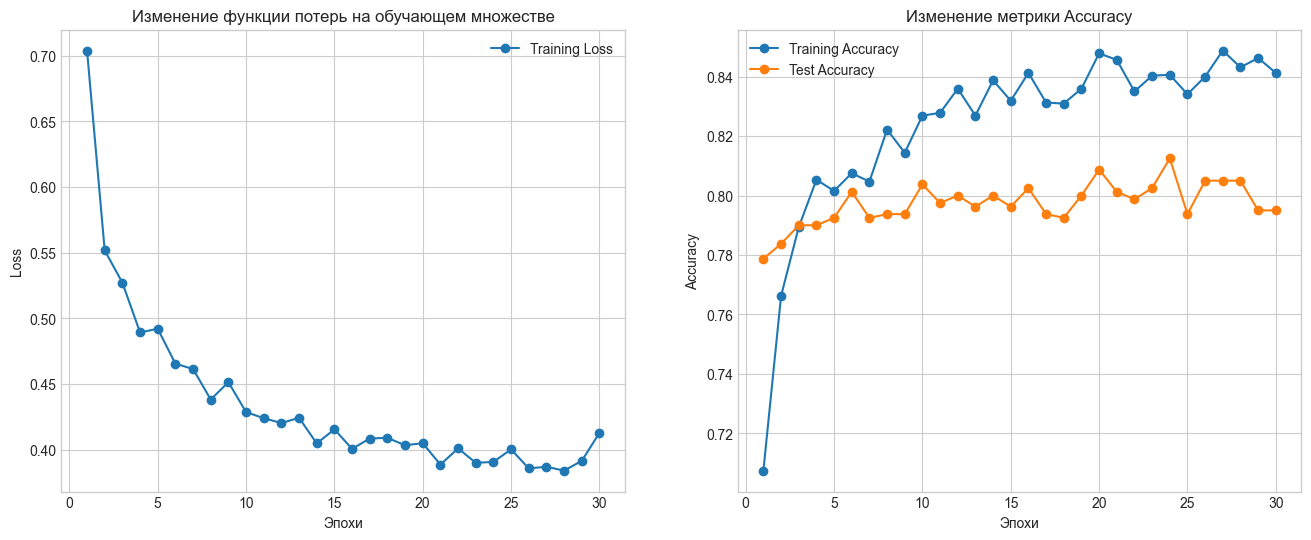

In [45]:
plt.style.use('seaborn-v0_8-whitegrid')
# График функции потерь
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))
ax1.plot(epochs_range, model_ft.history['train_loss'], 'o-', label='Training Loss')
ax1.set_title('Изменение функции потерь на обучающем множестве')
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Loss')
ax1.legend()

# График метрики accuracy
ax2.plot(epochs_range,model_ft.history['train_acc'], 'o-', label='Training Accuracy')
ax2.plot(epochs_range, model_ft.history['val_acc'], 'o-', label='Test Accuracy')
ax2.set_title('Изменение метрики Accuracy')
ax2.set_xlabel('Эпохи')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

<p class="task" id="4"></p>

4\. Повторите решение предыдущей задачи, заморозив все сверточные слои, кроме последнего (слои классификатора не замораживайте). Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей. Перед началом работы создайте модель заново.

- [ ] Проверено на семинаре

In [43]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [30]:
class PartialFineTuneVGG(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-4): # Используем меньший learning rate
        super().__init__()
        self.save_hyperparameters()

        weights = models.VGG16_Weights.DEFAULT
        self.model = models.vgg16(weights=weights)

        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.features[28].parameters():
             param.requires_grad = True
                
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_loss':[]}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.test_acc(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc, prog_bar=True)

    def on_train_epoch_end(self):
        self.history['train_loss'].append(self.trainer.callback_metrics['train_loss'].item())
        self.history['train_acc'].append(self.trainer.callback_metrics['train_acc'].item())

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking:
            self.history['val_acc'].append(self.trainer.callback_metrics['val_acc'].item())
            self.history['val_loss'].append(self.trainer.callback_metrics['val_loss'].item())


    def configure_optimizers(self):
        # Оптимизатор будет обновлять только размороженные веса
        return optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.hparams.learning_rate)

In [31]:
NUM_CLASSES = len(train_dataset.subset.dataset.classes)
MAX_EPOCHS = 30
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model_partial_ft = PartialFineTuneVGG(num_classes=NUM_CLASSES)

trainable_params_partial_ft = sum(p.numel() for p in model_partial_ft.parameters() if p.requires_grad)
print(f"Количество настраиваемых параметров после заморозки: {trainable_params_partial_ft:,}")

early_stop_callback = EarlyStopping(monitor='val_acc', patience=10, verbose=True, mode='max')
trainer_partial_ft = pl.Trainer(
    max_epochs=MAX_EPOCHS, 
    accelerator="auto", 
    callbacks=[TQDMProgressBar(refresh_rate=10), early_stop_callback]
)

trainer_partial_ft.fit(model_partial_ft, train_dataloaders=train_loader, val_dataloaders=test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Количество настраиваемых параметров после заморозки: 121,922,052



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG                | 134 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
121 M     Trainable params
12.4 M    Non-trainable params
134 M     Total params
537.108   Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.776


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.793


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.015 >= min_delta = 0.0. New best score: 0.808


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 10 records. Best score: 0.808. Signaling Trainer to stop.


15 минут 45 секунд на обучение с учетом работы от аккумулятора

In [32]:
test_results_partial_ft = trainer_partial_ft.test(model_partial_ft, dataloaders=test_loader, verbose=False)

final_train_acc_partial_ft = model_partial_ft.history['train_acc'][-1]
final_test_acc_partial_ft = test_results_partial_ft[0]['test_acc']
print(f"\nИтоговая точность на обучающем множестве: {final_train_acc_partial_ft:.4f}")
print(f"Итоговая точность на тестовом множестве: {final_test_acc_partial_ft:.4f}")

actual_epochs = len(model_partial_ft.history['train_loss'])
epochs_range = range(1, actual_epochs + 1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]


Итоговая точность на обучающем множестве: 1.0000
Итоговая точность на тестовом множестве: 0.7962


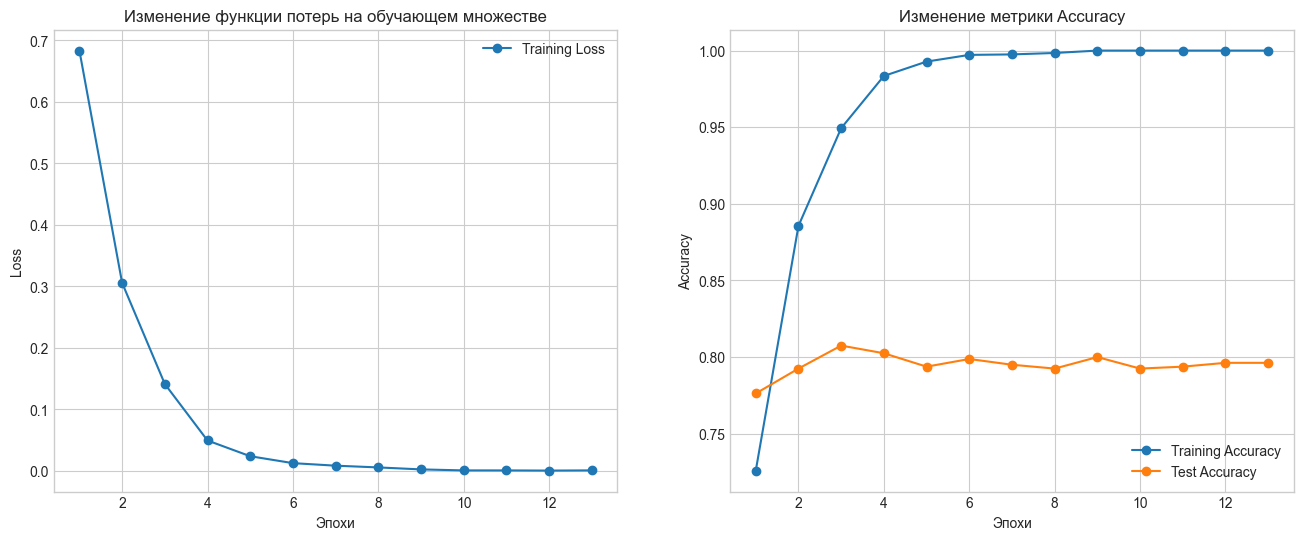

In [33]:
plt.style.use('seaborn-v0_8-whitegrid')
# График функции потерь
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))
ax1.plot(epochs_range, model_partial_ft.history['train_loss'], 'o-', label='Training Loss')
ax1.set_title('Изменение функции потерь на обучающем множестве')
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Loss')
ax1.legend()

# График метрики accuracy
ax2.plot(epochs_range,model_partial_ft.history['train_acc'], 'o-', label='Training Accuracy')
ax2.plot(epochs_range, model_partial_ft.history['val_acc'], 'o-', label='Test Accuracy')
ax2.set_title('Изменение метрики Accuracy')
ax2.set_xlabel('Эпохи')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

<p class="task" id="5"></p>

5\. Повторите решение задачи 3, расширив обучающий набор данных при помощи преобразований из `torchvision`, изменяющих изображение (повороты, изменение интенсивности пикселей, обрезание и т.д.). При оценке модели на тестовой выборке данные преобразования применяться не должны. Решение о том, сколько и каких слоев модели будет обучаться, примите самостоятельно. Перед началом работы создайте модель заново.

- [ ] Проверено на семинаре

In [ ]:
class PartialFineTuneVGG(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        weights = models.VGG16_BN_Weights.DEFAULT
        self.model = models.vgg16_bn(weights=weights)

        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.features[28].parameters():
             param.requires_grad = True
                
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_loss':[]}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.test_acc(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc, prog_bar=True)

    def on_train_epoch_end(self):
        self.history['train_loss'].append(self.trainer.callback_metrics['train_loss'].item())
        self.history['train_acc'].append(self.trainer.callback_metrics['train_acc'].item())

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking:
            self.history['val_acc'].append(self.trainer.callback_metrics['val_acc'].item())
            self.history['val_loss'].append(self.trainer.callback_metrics['val_loss'].item())

    def configure_optimizers(self):
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()), 
            lr=self.hparams.learning_rate,
            weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            'min', 
            factor=0.2, 
            patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss", 
            },
        }

In [27]:
train_transform_augmented = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)), # Случайное обрезание и изменение размера
    T.RandomHorizontalFlip(p=0.5),             # Горизонтальное отражение
    T.RandomRotation(degrees=15),              # Поворот
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Изменение цвета
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

vgg_weights = VGG16_Weights.IMAGENET1K_V1
test_transform = vgg_weights.transforms()


class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

full_dataset = ImageFolder(root=data_path)

generator = torch.Generator().manual_seed(42)
train_subset, test_subset = random_split(full_dataset, [0.8, 0.2], generator=generator)

train_dataset_aug = TransformedSubset(train_subset, transform=train_transform_augmented)
test_dataset_aug = TransformedSubset(test_subset, transform=test_transform)


In [28]:
NUM_CLASSES = len(train_dataset_aug.subset.dataset.classes)
MAX_EPOCHS = 20
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_aug, batch_size=BATCH_SIZE)

model_partial_ft = PartialFineTuneVGG(num_classes=NUM_CLASSES,learning_rate= 1e-4*3)

trainable_params_partial_ft = sum(p.numel() for p in model_partial_ft.parameters() if p.requires_grad)
print(f"Количество настраиваемых параметров после заморозки: {trainable_params_partial_ft:,}")

early_stop_callback = EarlyStopping(monitor='val_acc', patience=5, verbose=True, mode='max')
trainer_partial_ft = pl.Trainer(
    max_epochs=MAX_EPOCHS, 
    accelerator="auto", 
    callbacks=[early_stop_callback] # TQDMProgressBar(refresh_rate=10), 
)

trainer_partial_ft.fit(model_partial_ft, train_dataloaders=train_loader, val_dataloaders=test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Количество настраиваемых параметров после заморозки: 119,563,268



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG                | 134 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.142   Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.783


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.790


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.804


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.812


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.824


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.824. Signaling Trainer to stop.


22 с половиной минуты с учетом работы от аккумулятора

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]


Итоговая точность на обучающем множестве: 0.9347
Итоговая точность на тестовом множестве: 0.8188


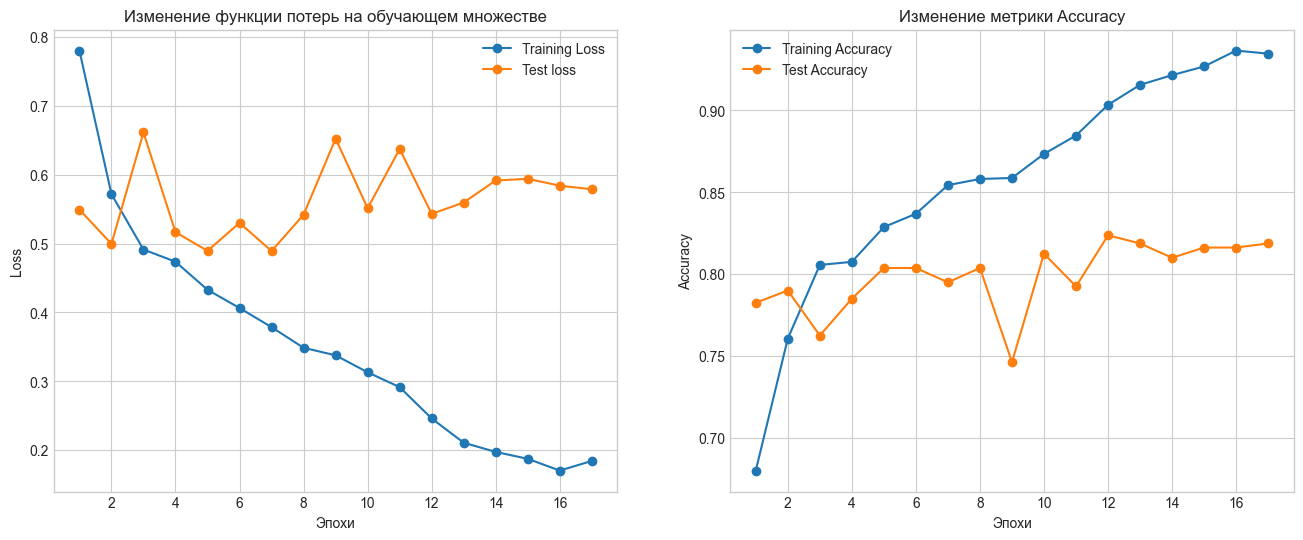

In [29]:
test_results_partial_ft = trainer_partial_ft.test(model_partial_ft, dataloaders=test_loader, verbose=False)

final_train_acc_partial_ft = model_partial_ft.history['train_acc'][-1]
final_test_acc_partial_ft = test_results_partial_ft[0]['test_acc']
print(f"\nИтоговая точность на обучающем множестве: {final_train_acc_partial_ft:.4f}")
print(f"Итоговая точность на тестовом множестве: {final_test_acc_partial_ft:.4f}")

actual_epochs = len(model_partial_ft.history['train_loss'])
epochs_range = range(1, actual_epochs + 1)

plt.style.use('seaborn-v0_8-whitegrid')
# График функции потерь
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))
ax1.plot(epochs_range, model_partial_ft.history['train_loss'], 'o-', label='Training Loss')
ax1.plot(epochs_range, model_partial_ft.history['val_loss'], 'o-', label='Test loss')
ax1.set_title('Изменение функции потерь на обучающем множестве')
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Loss')
ax1.legend()

# График метрики accuracy
ax2.plot(epochs_range,model_partial_ft.history['train_acc'], 'o-', label='Training Accuracy')
ax2.plot(epochs_range, model_partial_ft.history['val_acc'], 'o-', label='Test Accuracy')
ax2.set_title('Изменение метрики Accuracy')
ax2.set_xlabel('Эпохи')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()